## Anime Recommendation System

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Dense,Dropout,Input,Embedding,Flatten,Dot
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler,TensorBoard
from wordcloud import WordCloud

%matplotlib inline


### Read Animelist.csv file 

In [95]:
import os 

INUPT_DIR = os.path.join("..","artifacts","raw")


In [96]:
rating_df = pd.read_csv(os.path.join(INUPT_DIR + "/animelist.csv"),nrows=5000000,low_memory=True,usecols=['user_id','anime_id','rating'])
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [97]:
rating_df.shape

(5000000, 3)

### Data Processing

* **Step 1:** We are going to find out effecient user ,means user those who watched the anime more than a threshold [200] are called active user . From this users we can recommend to other users who has the similarity as well as these data are help the model to learn the pattern from them . If we pass the users who watch anime less than 10 we consider them has inactive users or infrequent users.


In [98]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
rating_df.shape
                      

(3246641, 3)

In [99]:
rating_df['user_id'].value_counts()

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
4125       400
4776       400
8812       400
4529       400
8213       400
Name: count, Length: 4203, dtype: int64

In [100]:
min_rating = rating_df['rating'].min()
min_rating

np.int64(0)

In [101]:
max_rating = rating_df['rating'].max()
max_rating

np.int64(10)

In [102]:
avg_rating = rating_df['rating'].mean()
avg_rating

np.float64(4.122732695114736)

After filtering active user from the rating_df ,we find min,max and avg of ratings . We know that rating 1 to 10 will influence the model which has high value. So we are going to do Feature scalling on rating column to bring the values between 0 and 1 . 

In [103]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating - min_rating)).values.astype(np.float64)
rating_df['rating'].head()

213    0.0
214    1.0
215    0.0
216    0.0
217    0.0
Name: rating, dtype: float64

In [104]:
print("min_rating:",rating_df['rating'].min())
print("max_rating:",rating_df['rating'].max())
print("avg_rating:",rating_df['rating'].mean())

min_rating: 0.0
max_rating: 1.0
avg_rating: 0.4122732695114729


* Check the duplicate is present or not 
* Check for Missing values

In [105]:
rating_df.duplicated().sum()

np.int64(0)

In [106]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

There is no missing values and Duplicate present in the rating_df.

### Next Step- Encode and Decode the user_id and anime_id

* To do that we first need to list out all the unique user_id and anime_id. 

* Then we loop the user_id with enumerate() to assign each id with unique number.

* So this make the user_id encoded and we will make use of this encoded feature for our model training.

In [107]:
user_ids = rating_df['user_id'].unique().tolist()
anime_ids = rating_df['anime_id'].unique().tolist()

# Encode user ids 
user2user_encoded = { x:i for i,x in enumerate(user_ids)}

# Encode anime ids
anime2anime_encoded = {x:i for i,x in enumerate(anime_ids)}

# Decode user ids 
user_encoded2user = {i:x for i,x in enumerate(user_ids)}

# Decode anime ids
anime_encoded2anime = {i:x for i,x in enumerate(anime_ids)}


# Map the encoded values in the rating_df with new columns name user and anime 
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

rating_df.head()



,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


After encode user_id and anime_id with new column with name user and anime , we count the length of the unique anime and user from rating_df and store in n_anime and n_user to define the layers in tensorflow. 

In [108]:
n_user = len(user2user_encoded)
n_anime = len(anime2anime_encoded)

print("Number of unique anime_id:",n_anime)
print("Number of unique user_id:",n_user)

Number of unique anime_id: 17149
Number of unique user_id: 4203


Now we are going to suffle the data to prevent from data leakage and our model to learn from random sample. 

In [109]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)


Split the data into X and y 

In [110]:
X = rating_df[['user','anime']].values
y = rating_df['rating'].values

# Split the data into train and test with test_size = 1000
test_size =1000
train_indices = rating_df.shape[0] - test_size

X_train,X_test, y_train,y_test = (X[:train_indices],X[train_indices:],y[:train_indices],y[train_indices:])

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (3245641, 2)
X_test shape: (1000, 2)
y_train shape: (3245641,)
y_test shape: (1000,)


In [111]:
type(X_train)

numpy.ndarray

In [112]:
X_train

array([[3405,  688],
       [4060, 1518],
       [1213, 4963],
       ...,
       [ 560, 1461],
       [3815, 1512],
       [2122, 1153]], shape=(3245641, 2))

we need to split the feature_1 and feature_2 with seperate 

In [113]:
X_train_array = [X_train[:,0],X_train[:,1]]
X_test_array = [X_test[:,0],X_test[:,1]]

X_train_array

[array([3405, 4060, 1213, ...,  560, 3815, 2122], shape=(3245641,)),
 array([ 688, 1518, 4963, ..., 1461, 1512, 1153], shape=(3245641,))]

### Model Architecture:

In [114]:
def recommenderNet():
    ### Model Architecture:
    embedding_size = 128

    # User Input Layer
    user = Input(name="user",shape=[1])

    # User Embedding Layer
    user_embedding = Embedding(input_dim=n_user,output_dim=embedding_size,name='user_embedding')(user)

    # Anime Input Layer 
    anime = Input(name="anime",shape=[1])

    # Anime Embedding Layer 
    anime_embedding = Embedding(input_dim=n_anime,output_dim=embedding_size,name="anime_embedding")(anime)

    # Dot Product of User and Anime Embedding Layer
    x = Dot(name="dot_product",normalize=True,axes=2)([user_embedding,anime_embedding])

    # Flatten Layer
    x = Flatten()(x)

    # Dense Layer 
    x = Dense(1,kernel_initializer="he_normal",name="dense_layer")(x)

    # Batch Normalization Layer
    x = BatchNormalization()(x)

    # Activation Layer
    x = Activation("sigmoid")(x)

    # Create Model 
    model = Model(inputs=[user,anime],outputs=x)

    # Compile the Model 
    model.compile(loss= "binary_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["mse","mae"])

    return model




In [115]:
model = recommenderNet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

Now we will train our model , before that we will specified some callback.

In [116]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
expo_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        lr = (max_lr - start_lr)/ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        lr = max_lr
    else:
        lr = (max_lr - min_lr) * expo_decay**(epoch - ramup_epochs - sustain_epochs) + min_lr
    return lr

In [117]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch),verbose=0)
checkpoint_filepath = "./weights.weights.h5"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)
early_stopping = EarlyStopping(patience =3,monitor="val_loss",mode="min",restore_best_weights=True)


In [118]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [119]:
history = model.fit(x=X_train_array,y=y_train,batch_size=batch_size,epochs=20,verbose=1,validation_data=(X_test_array,y_test),callbacks=my_callbacks)


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.7770 - mae: 0.3780 - mse: 0.1897 - val_loss: 0.7015 - val_mae: 0.3659 - val_mse: 0.1610 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.7736 - mae: 0.3768 - mse: 0.1883 - val_loss: 0.7517 - val_mae: 0.3766 - val_mse: 0.1817 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.7679 - mae: 0.3747 - mse: 0.1860 - val_loss: 0.7694 - val_mae: 0.3796 - val_mse: 0.1877 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.7599 - mae: 0.3715 - mse: 0.1827 - val_loss: 0.7662 - val_mae: 0.3787 - val_mse: 0.1864 - learning_rate: 3.4000e-05


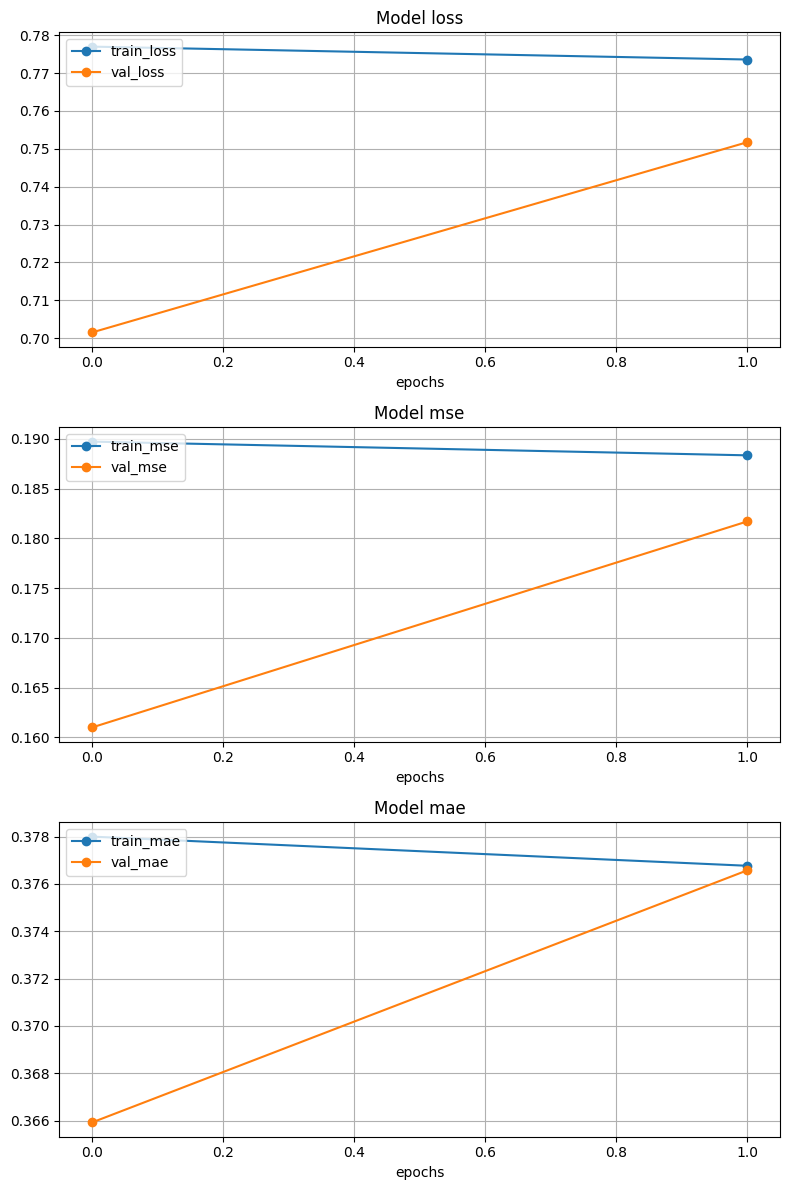

In [120]:
# Visualize the loss 
metrics = ['loss','mse','mae']

fig,axes = plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))
for i,metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2],marker="o",label="train_"+metric)
    ax.plot(history.history["val_"+metric][0:-2],marker="o",label="val_"+metric)
    ax.set_title("Model "+metric)
    ax.set_xlabel("epochs")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

Extract weights from the model 

In [121]:
def extract_weights(name,model):
  weight_layer = model.get_layer(name)
  weights = weight_layer.get_weights()[0]
  weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))

  return weights

In [122]:
anime_weights = extract_weights("anime_embedding",model)


In [123]:
anime_weights

array([[-0.03403928,  0.07870478, -0.1383674 , ..., -0.13245228,
        -0.07227659, -0.12450536],
       [ 0.06224719, -0.09732091,  0.14501472, ..., -0.08854613,
         0.08373858, -0.05603916],
       [ 0.07478878, -0.07092151, -0.03945931, ..., -0.05110902,
        -0.05525918, -0.0745613 ],
       ...,
       [ 0.13980903,  0.07759811,  0.11999735, ..., -0.06718461,
        -0.04107239,  0.04735143],
       [-0.00950492, -0.0681078 , -0.01898305, ..., -0.10545764,
        -0.06673544,  0.02219232],
       [-0.06755771,  0.0021226 , -0.13213053, ...,  0.07066151,
        -0.09493858,  0.0328439 ]], shape=(17149, 128), dtype=float32)

In [124]:
user_weights = extract_weights("user_embedding",model)

In [125]:
user_weights

array([[ 0.05727955, -0.00920083, -0.0614018 , ...,  0.1295213 ,
        -0.02456462,  0.13542026],
       [-0.06577433, -0.10565574, -0.1385623 , ..., -0.03528768,
         0.01387411, -0.04410938],
       [-0.0718675 ,  0.12048506, -0.10195003, ...,  0.07742667,
         0.11132097,  0.0924    ],
       ...,
       [-0.11777636,  0.00833571, -0.09463817, ...,  0.08013876,
        -0.00359136,  0.1561121 ],
       [ 0.14604758,  0.09550169,  0.07779531, ...,  0.10252903,
         0.1014117 ,  0.02085754],
       [-0.10051665, -0.04628105, -0.06850027, ..., -0.13517855,
        -0.04836933, -0.00402271]], shape=(4203, 128), dtype=float32)

### Reading Anime.csv

In [126]:
df = pd.read_csv(INUPT_DIR+"/anime.csv",low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [127]:
df = df.replace("Unknown",np.nan)

In [128]:
df['Name'].isna().sum()

np.int64(0)

In [129]:
df['English name'].isna().sum() # 10565 MAL ID has no English Name .

np.int64(10565)

Now we are going to impute the filling name with function **getAnimeName()** which take MAL_ID has input and check whether it has English name if it doesn't have english name it take form Name column which has english name for all anime id .

In [130]:
def getAnimeName(anime_id):
  try:
    name = df[df.MAL_ID == anime_id]["English name"].values[0]
    if name is np.nan:
      name = df[df.MAL_ID == anime_id]["Name"].values[0]
  except:
    print("Error")

  return name

In [131]:
## id without english name are 15,17 for example purpose
getAnimeName(17)

'Hungry Heart: Wild Striker'

In [132]:
df["eng_version"] = df['MAL_ID'].apply(lambda x: getAnimeName(x))
df["eng_version"].isna().sum()

np.int64(0)

Sort the dataframe with Score column with high to low .

In [133]:
df.sort_values(by=["Score"], ascending=False,inplace=True,kind="quicksort",na_position="last")

In [134]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,63756.0,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,275960.0,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,239451.0,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,37902.0,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,Gintama Season 4


In [135]:
df = df[["MAL_ID","eng_version","Score","Genres","Episodes","Type","Premiered","Studios","Members"]]
df.head()

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,Bones,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,MAPPA,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,White Fox,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,Wit Studio,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,Bandai Namco Pictures,404121


In [136]:
def getAnimeFrame(anime,df):
  if isinstance(anime,int):
    return df[df['MAL_ID'] == anime]
  if isinstance(anime,str):
    return df[df['eng_version'] == anime]


In [137]:
getAnimeFrame(5114,df)

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,Bones,2248456


In [138]:
getAnimeFrame("Attack on Titan Final Season",df)

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,MAPPA,733260


### Read Anime_with_sysnopsis.csv

In [139]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]
synopsis_df = pd.read_csv(INUPT_DIR+"/anime_with_synopsis.csv",usecols=cols,low_memory=True)
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [140]:
synopsis_df.shape

(16214, 4)

In [141]:
synopsis_df.isna().sum()

MAL_ID       0
Name         0
Genres       0
sypnopsis    8
dtype: int64

In [142]:
synopsis_df['sypnopsis'] = synopsis_df['sypnopsis'].fillna("NO synopsis")

In [143]:
def getSypnopsis(anime,df):
  if isinstance(anime,int):
    return synopsis_df[synopsis_df['MAL_ID'] == anime]['sypnopsis'].values[0]
  if isinstance(anime,str):
    return synopsis_df[synopsis_df['Name'] == anime]['sypnopsis'].values[0]

In [144]:
getSypnopsis("Witch Hunter Robin",synopsis_df)

"ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"

### Content/Item Based Recommendation system

In [145]:
pd.set_option('display.max_colwidth', None)

In [146]:
def find_similar_animes(name,anime_weights,anime2anime_encoded,
                        encoded2anime,df,synopsis_df,n=10,return_dist=False,neg=False):

  try:
    index = getAnimeFrame(name,df).MAL_ID.values[0]
    encoded_index = anime2anime_encoded.get(index)
    weights = anime_weights


    dists = np.dot(weights,weights[encoded_index])

    sorted_dists = np.argsort(dists)

    n = n+1

    if neg:
      closest = sorted_dists[:n]

    else:
      closest = sorted_dists[-n:]


    print(f" Anime closest to {name}")

    if return_dist:
      return dists,closest

    similarityArr = []

    for close in closest:
      decoded_id = encoded2anime.get(close)

      # synopsis = getSypnopsis(decoded_id,synopsis_df)


      anime_frame = getAnimeFrame(decoded_id,df)

      anime_name = anime_frame.eng_version.values[0]

      genre = anime_frame.Genres.values[0]

      similarity = dists[close]


      similarityArr.append(
          {
              "anime_id":decoded_id,
              "anime_name":anime_name,
              "genre":genre,
              "similarity":similarity,
              # "synopsis":synopsis
          }
      )

    Frame = pd.DataFrame(similarityArr).sort_values(by="similarity",ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

  except Exception as e :
    print("Error Occurs ",e)



In [147]:
find_similar_animes("Gintama Season 4",
                    anime_weights,
                    anime2anime_encoded,
                    anime_encoded2anime,
                    df,
                    synopsis_df)

 Anime closest to Gintama Season 4


,anime_name,genre,similarity
9,Timing,"Psychological, Horror",0.331719
8,Ninja Tamamaru: Rule wo Mamotte Koutsuu Anzen! no Maki,"Kids, Martial Arts",0.321858
7,Keroppi in Our Treasure,"Fantasy, Kids",0.318609
6,Sore Ike! Anpanman: Inochi no Hoshi no Dolly,"Fantasy, Kids, Magic",0.313209
5,Mezzo Forte,"Action, Comedy, Hentai, Sci-Fi",0.294587
4,Chiruran 1/2,"Action, Comedy, Historical",0.294066
3,Kai Doh Maru,"Action, Fantasy, Historical, Magic",0.293475
2,Here Comes the Black Witch!!,"Comedy, Magic, School, Slice of Life",0.291959
1,Sotsugyou Mae: 10-hi de 100 no Dekigoto,"Kids, Music",0.290801
0,Punishment,Hentai,0.289947


### USER BASED RECOMMENDATION

In [148]:
def find_similar_users(item_input,user_weights,user2user_encoded,
                       encoded2user,n=10,return_dist=False,neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weights = user_weights
        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        
        if return_dist:
            return dists,closest
        
        similarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = encoded2user.get(close)
                similarityArr.append(
                    {
                        "similiar_users":decoded_id,
                        "similarity":similarity
                    }
                )
        
        similar_users = pd.DataFrame(similarityArr).sort_values(by="similarity",ascending=False)
        return similar_users[similar_users.similiar_users != item_input]
    except Exception as e:
        print("Error Occurs ",e)


In [149]:
find_similar_users(11880,user_weights,user2user_encoded,
                   user_encoded2user,n=10,return_dist=False,neg=False)

,similiar_users,similarity
8,16487,0.292169
7,10729,0.282269
6,8746,0.269837
5,15035,0.267558
4,3409,0.261725
3,14774,0.251955
2,10032,0.250008
1,13892,0.246231
0,2768,0.243817


In [150]:
def showWordCloud(all_genres):
  genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
  plt.figure(figsize=(10,5))
  plt.imshow(genres_cloud,interpolation="bilinear")
  plt.axis('off')
  plt.show()

In [151]:
from collections import defaultdict

In [152]:
def getFavGenre(frame, plot=False):
  frame.dropna(inplace=False)
  all_genres = defaultdict(int)
  genres_list = []

  for genres in frame["Genres"]:
    if isinstance(genres,str):
      for genre in genres.split(','):
        genres_list.append(genre)

        all_genres[genre.strip()] +=1

  if plot:
    showWordCloud(all_genres)

  return genres_list

In [153]:
x= getAnimeFrame(1,df)
x

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,Sunrise,1251960


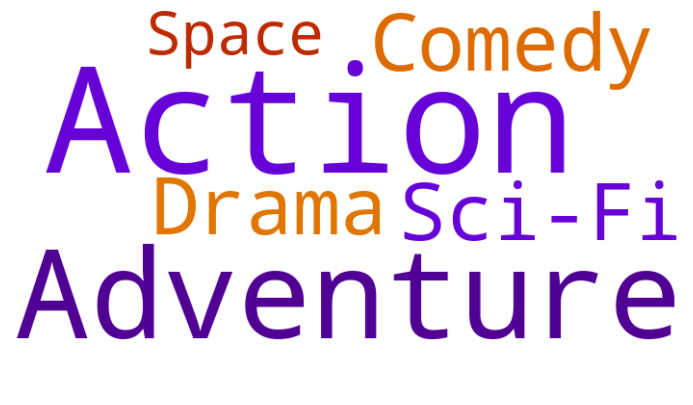

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [154]:
getFavGenre(x,plot=True)

In [155]:
def get_user_preferences(user_id,rating_df,df,plot=False):

    animes_watched_by_user = rating_df[rating_df['user_id']== user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user['rating'],75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user['rating'] >= user_rating_percentile]

    top_anime_user = (
        animes_watched_by_user.sort_values(by='rating',ascending=False).anime_id.values
    )

    anime_df_rows = df[df['MAL_ID'].isin(top_anime_user)]

    anime_df_rows = anime_df_rows[['eng_version','Genres']]

    
    if plot:
        getFavGenre(anime_df_rows,plot=plot)


    return anime_df_rows




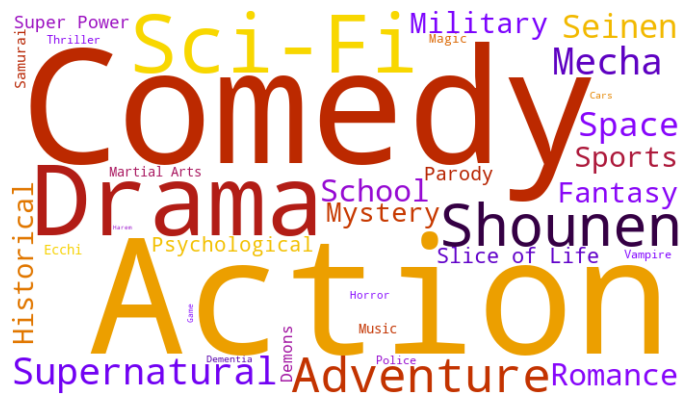

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [156]:
get_user_preferences(11880,rating_df,df,plot=True)

### user_recommendation

In [193]:
def get_user_recommendations(similar_users,user_preferences,df,synopsis_df,rating_df,n=10):

    recommended_animes = []
    anime_list =[]
    for user_id in similar_users['similiar_users'].values:
        # print("Similar User ID:",user_id)
        pref_list = get_user_preferences(int(user_id),rating_df,df)

        pref_list = pref_list[~pref_list['eng_version'].isin(user_preferences['eng_version'].values)]
       

        if not pref_list.empty:
            lists = pref_list['eng_version'].values
            anime_list.append(lists)

                    
    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i,anime_name in enumerate(sorted_list.index):

            n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name,str):
                frame = getAnimeFrame(anime_name,df)
                
                anime_id = frame.MAL_ID.values[0]
              
                genre = frame.Genres.values[0]
                synopsis = getSypnopsis(int(anime_id),synopsis_df)
             
                recommended_animes.append(
                    {
                        "n" : n_user_pref,
                        "anime_name":anime_name,
                        "genre":genre,
                        "synopsis":synopsis
                    }
                )
    recommended_animes_df = pd.DataFrame(recommended_animes).head(n)
    return recommended_animes_df

In [194]:
similar_users = find_similar_users(11880,user_weights,user2user_encoded,
                     user_encoded2user,n=10,return_dist=False,neg=False)
user_preferences = get_user_preferences(11880,rating_df,df,plot=False)


In [195]:
get_user_recommendations(similar_users,user_preferences,df,synopsis_df,rating_df,n=10)

,n,anime_name,genre,synopsis
0,8,Angel Beats!,"Action, Comedy, Drama, School, Supernatural","Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Unable to believe Yuri's claims that Tenshi is evil, Otonashi attempts to speak with her, but the encounter doesn't go as he intended. Otonashi decides to join the SSS and battle Tenshi, but he finds himself oddly drawn to her. While trying to regain his memories and understand Tenshi, he gradually unravels the mysteries of the afterlife."
1,8,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
2,8,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
3,7,My Hero Academia 3,"Action, Comedy, Super Power, School, Shounen","s summer arrives for the students at UA Academy, each of these superheroes-in-training puts in their best efforts to become renowned heroes. They head off to a forest training camp run by UA's pro heroes, where the students face one another in battle and go through dangerous tests, improving their abilities and pushing past their limits. However, their school trip is suddenly turned upside down when the League of Villains arrives, invading the camp with a mission to capture one of the students. Boku no Hero Academia 3rd Season follows Izuku ""Deku"" Midoriya, an ambitious student training to achieve his dream of becoming a hero similar to his role model—All Might. Being one of the students caught up amidst the chaos of the villain attack, Deku must take a stand with his classmates and fight for their survival."
4,7,My Teen Romantic Comedy SNAFU,"Slice of Life, Comedy, Drama, Romance, School","Hachiman Hikigaya is an apathet

### HYBRID RECOMMENDER SYSTEM

In [180]:
similar_users = find_similar_users(11880,user_weights,user2user_encoded,
                     user_encoded2user,n=10,return_dist=False,neg=False)
similar_users

,similiar_users,similarity
8,16487,0.292169
7,10729,0.282269
6,8746,0.269837
5,15035,0.267558
4,3409,0.261725
3,14774,0.251955
2,10032,0.250008
1,13892,0.246231
0,2768,0.243817


In [196]:
def hybrid_recommendation(user_id,user_weights=0.5,content_weights=0.5):
    # Get similar users
    similar_users_ = find_similar_users(11880,user_weights,user2user_encoded,
                     user_encoded2user,n=10)
    # print(similar_users_)
    
    # Get user preferences
    user_preferences = get_user_preferences(user_id,rating_df,df,plot=False)
    # print("User_preferences:",user_preferences)
    
    # Get recommendations based on similar users
    recommendations = get_user_recommendations(similar_users,user_preferences,df,synopsis_df,rating_df,n=10)
    # print(recommendations)
    
    user_recommended_animes_list = recommendations['anime_name'].tolist()
    # print("User based recommended animes:",user_recommended_animes_list)
    
    # Get content-based recommendations
    content_recommended_animes = []
    for anime in user_recommended_animes_list:
        similar_animes = find_similar_animes(anime,anime_weights,anime2anime_encoded,
                                            anime_encoded2anime,df,synopsis_df,n=5,return_dist=False,neg=False)
        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes['anime_name'].tolist())
        else:
            print(f"No similar animes found for {anime}")
        
    
    combine_scores = {}
    for anime in user_recommended_animes_list:
        combine_scores[anime] = combine_scores.get(anime, 0) + user_weights
    for anime in content_recommended_animes:
        combine_scores[anime] = combine_scores.get(anime, 0) + content_weights
    
    sorted_animes = sorted(combine_scores.items(), key=lambda x: x[1], reverse=True)
    
    return [anime for anime,score in sorted_animes[:10]]


In [198]:
hybrid_recommendation(13994)

Error Occurs  'float' object is not subscriptable
 Anime closest to Angel Beats!
 Anime closest to The Girl Who Leapt Through Time
 Anime closest to Food Wars! Shokugeki no Soma
 Anime closest to My Hero Academia 3
 Anime closest to GATE
 Anime closest to Elfen Lied
 Anime closest to Death Parade
 Anime closest to My Hero Academia
 Anime closest to Terror in Resonance
 Anime closest to Dr. Stone


['Angel Beats!',
 'The Girl Who Leapt Through Time',
 'Food Wars! Shokugeki no Soma',
 'My Hero Academia 3',
 'GATE',
 'Elfen Lied',
 'Death Parade',
 'My Hero Academia',
 'Terror in Resonance',
 'Dr. Stone']